## Exploring data


In [73]:
import pandas as pd
import sqlite3
import requests
import matplotlib.pyplot as plt

### movie_gross CSV file

In [26]:
movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### tmdb_movie CSV file

In [107]:
tmdb_movie = pd.read_csv("zippedData/tmdb.movies.csv.gz")
tmdb_movie.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [60]:
tmdb_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


From calling the `.info()` method, there seems to be no missing values to deal with. However, the `genre_ids` column is notable because it contains strings that appear to be lists with numerical values.

Since all `genre_ids` are encoded, we match the numeric codes to the actual genre strings, based on information found [here](https://www.themoviedb.org/talk/5f58b094befb0900355684a6), and create another column called `genre` that contains a list of genres.

In [108]:
# A dictionary containing the genre_ids as keys and genres as values
tmdb_genre_list = {
            '28': 'Action',
            '12': 'Adventure',
            '16': 'Animation',
            '35': 'Comedy',
            '80': 'Crime',
            '99': 'Documentary',
            '18': 'Drama',
            '10751': 'Family',
            '14': 'Fantasy',
            '36': 'History',
            '27': 'Horror',
            '10402': 'Music',
            '9648': 'Mystery',
            '10749': 'Romance',
            '878': 'ScienceFiction',
            '10770': 'TVMovie',
            '53': 'Thriller',
            '10752': 'War',
            '37': 'Western'
}

In [109]:
# Changing format of genre_ids to a list
# Note that the numerical values are still in strings

tmdb_movie['genre_ids'] = tmdb_movie['genre_ids'].str.strip('][').str.split(', ')
tmdb_movie['genre_ids'].head()

0        [12, 14, 10751]
1    [14, 12, 16, 10751]
2          [12, 28, 878]
3        [16, 35, 10751]
4          [28, 878, 12]
Name: genre_ids, dtype: object

In [110]:
def clean_genre(genre):
    new_genre = None
    if genre[0] in tmdb_genre_list.keys():
        new_genre = tmdb_genre_list[genre[0]]
    else:
        new_genre = 'Unknown'       
    return new_genre

tmdb_movie['genre'] = tmdb_movie['genre_ids'].map(clean_genre)

tmdb_movie['genre'].value_counts()


genre
Drama             4923
Documentary       4407
Comedy            3632
Unknown           2479
Horror            2209
Action            1651
Thriller          1533
Animation          917
Romance            694
Music              678
ScienceFiction     572
Adventure          545
Crime              538
Family             459
TVMovie            365
Fantasy            317
Mystery            287
History            127
War                103
Western             81
Name: count, dtype: int64

One of the notable categories is the **Unknown** category. This category may contain a numeric genre_id that is not specified in the `tmdb_genre_list` dictionary, or have no numeric id. Since there are 2479 entries with the **Unknown** out of about 26500, we decide to drop the movies that have the **Unknown** category.

In [111]:
tmdb_movie = tmdb_movie.loc[tmdb_movie['genre'] != 'Unknown']
tmdb_movie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24038 entries, 0 to 26516
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         24038 non-null  int64  
 1   genre_ids          24038 non-null  object 
 2   id                 24038 non-null  int64  
 3   original_language  24038 non-null  object 
 4   original_title     24038 non-null  object 
 5   popularity         24038 non-null  float64
 6   release_date       24038 non-null  object 
 7   title              24038 non-null  object 
 8   vote_average       24038 non-null  float64
 9   vote_count         24038 non-null  int64  
 10  genre              24038 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 2.2+ MB


Text(0, 0.5, 'Number of Movies')

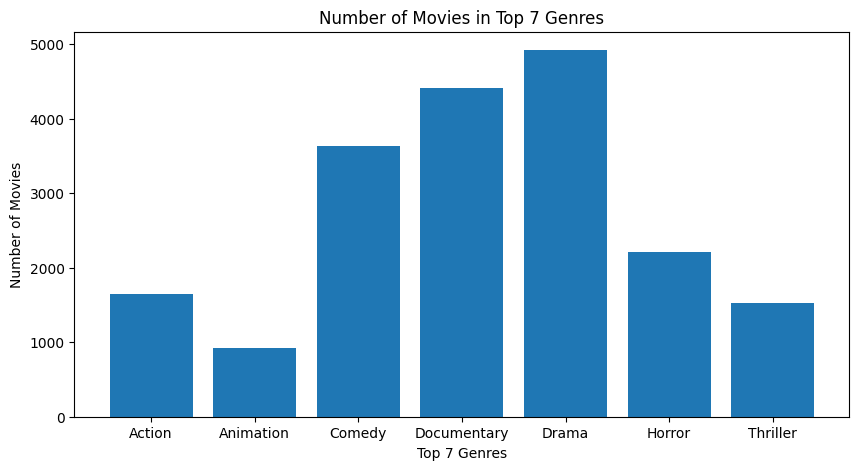

In [128]:
# Visualizing the number of movies in top 5 movie genres
top_7_genres_index = list(tmdb_movie['genre'].value_counts()[:7].keys())
top_7_genre_counts = tmdb_movie['genre'].value_counts()[:7]
top_7_genres = dict(zip(top_7_genres_index, top_7_genre_counts))
top_7_genres_index.sort()
top_7_genres_index
top_7_genres_sorted = {i: top_7_genres[i] for i in top_7_genres_index}
top_7_genres_sorted

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(top_7_genres_sorted.keys(), top_7_genres_sorted.values())
ax.set_title("Number of Movies in Top 7 Genres")
ax.set_xlabel("Top 7 Genres")
ax.set_ylabel("Number of Movies")


In [116]:
# Grouping by genre for top 7 genre, and getting the vote average
genre_tmdb = tmdb_movie.loc[tmdb_movie['genre'].isin(top_7_genres)].groupby('genre')
genre_tmdb['vote_average'].mean()

genre
Action         5.574258
Animation      6.405016
Comedy         5.941189
Documentary    6.808101
Drama          6.139691
Horror         4.699502
Thriller       5.228245
Name: vote_average, dtype: float64

Text(0, 0.5, 'Average Ratings')

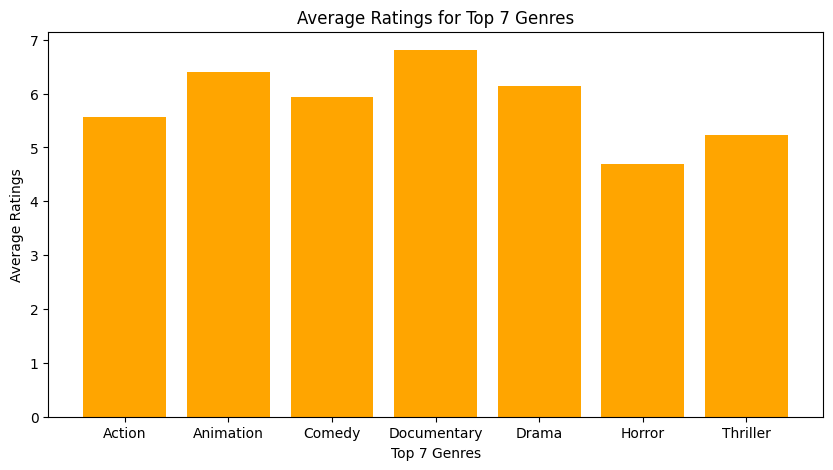

In [130]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(genre_tmdb['vote_average'].mean().keys(), genre_tmdb['vote_average'].mean(), color='orange')
ax.set_title("Average Ratings for Top 7 Genres")
ax.set_xlabel("Top 7 Genres")
ax.set_ylabel("Average Ratings")

### tn_movie_budgests CSV file

In [10]:
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [20]:
movie_info = pd.read_table("zippedData/rt.movie_info.tsv.gz")
movie_info.head()


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [25]:
reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", sep='\t', encoding='latin1')
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In order to unzip the database file, run the following prompt in terminal

`tar -xf "zippedData/im.db.zip"`

In [4]:
conn = sqlite3.connect("im.db")


In [4]:
pd.read_sql("""
SELECT *
FROM persons
""", conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer
